## Read in a data set for Mid-Term 1 EOF project in python
This reads in the two dimensional array made by Midterm1.ipynb, then does eof analysis of it.

 D.L. Hartmann January 25, 2023 <br/>
MidTerm_1b.ipynb  <br/>

 data file I made was test2.nc<br/>
 <br/>
<br/>


In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

#from scipy.io import netcdf
#from scipy.io import loadmat
#from scipy.interpolate import griddata
import scipy.signal as sig
#import xarray as xr
#from cartopy import config
#import cartopy.crs as ccrs
#import pandas as pd
#import netCDF4 as nc
#import warnings
#from cartopy import config
#import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


<class 'netCDF4._netCDF4.Variable'>
float32 space(space)
    units: degrees
    long_name: some kind of distance
unlimited dimensions: 
current shape = (30,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    units: days
    long_name: time
unlimited dimensions: 
current shape = (120,)
filling on, default _FillValue of 9.969209968386869e+36 used
[[  3.64078613   4.10294351   5.98701075 ...   9.89764724   1.18768387
    9.30702333]
 [ -3.10671566  -3.39176575   2.40281307 ... -13.64444018  -6.5706031
   -2.07921068]
 [  0.51868651  15.99752102  15.47613577 ...  -5.62037431 -12.58847295
   -4.76593371]
 ...
 [  5.36148547  -3.77142126  -5.60743888 ...  -6.17303746  -5.72239848
   -1.27397188]
 [  9.43443117  -0.23972064  -4.07488217 ...  -0.1063106   -9.0139925
    1.30061389]
 [ 14.95000104   8.45003044   1.06861818 ...   1.26485957  -8.69264867
   -3.93139537]]
type x  <class 'numpy.ndarray'>
type x  <class 'numpy.nda

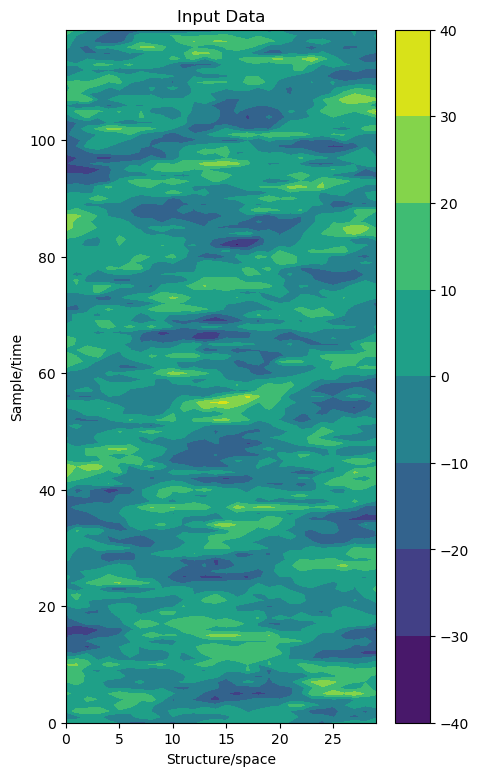

In [60]:
# Start by reading in the data the sample space N and the state space M
ncfile ='test3.nc' 
ds = nc.Dataset(ncfile)
#print(ds.variables.keys()) # get all variable names

xnc = ds.variables['value']
space = ds.variables['space']
time = ds.variables['time']
x = np.ma.getdata(xnc, subok=False)

de_trend = True
if de_trend:
    x = sig.detrend(x,axis=0)
    #x = sig.detrend(x,axis=1)
print(space)
print(time)
print(x)
print('type x ',type(x))

#for dim in ds.dimensions.values():
#    print(dim)
#for var in ds.variables.values():
#    print(var)    
#print(ds['value'])
#x = ds['value'][:]

print('type x ',type(x))
x = x.T    # difference between how I stored data and how I computed it
time = ds['time'][:]
space = ds['space'][:]
print('Shape x ',np.shape(x))    
N = len(time)
M = len(space)
# plot the input data


plt.figure(figsize=(5,9))
plt.contourf(x.T)
plt.title('Input Data')
plt.xlabel('Structure/space')
plt.ylabel('Sample/time')
plt.colorbar()
# Ok, now I think we have an array x that is [M,N]  
# First let's estimate the number of degrees of freedom in the sample by estimating a grand autocorrelation




def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.nanmean(x)
    var=np.nanvar(x)
    if var == 0.0:
        var=1.0e-6
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    #corr=[ np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)
xcor = np.zeros([2])

nt, ns = np.shape(x)
print('nt',nt,'ns',ns)
print(type(ns))

lags = [0,1]
for i in range(ns):
    xx=np.squeeze(x[:,i])
    xcor1 = autocorr2(xx,lags)
    xcor = xcor + xcor1

print('xx',xx[0:4],xx[-4:])    
xcor = xcor/float(ns)
print('xcor ',xcor)
acorr = xcor[1]
dof_x = N*(1. - acorr**2)/(1. + acorr**2)
print('DOF = ',dof_x,',   DOF/N = ',dof_x/N,',  N = ',N)


shape c  (30, 30)
u shape (30, 30)
vh shape (120, 120)
s shape (30,)
tsamp  [[ 1.00000000e+00 -3.77302356e-17 -1.56992475e-16  3.90312782e-17]
 [-3.77302356e-17  1.00000000e+00 -1.37043155e-16  1.35308431e-16]
 [-1.56992475e-16 -1.37043155e-16  1.00000000e+00 -1.90819582e-17]
 [ 3.90312782e-17  1.35308431e-16 -1.90819582e-17  1.00000000e+00]]
years shape (120,)
ts shape (4, 120)


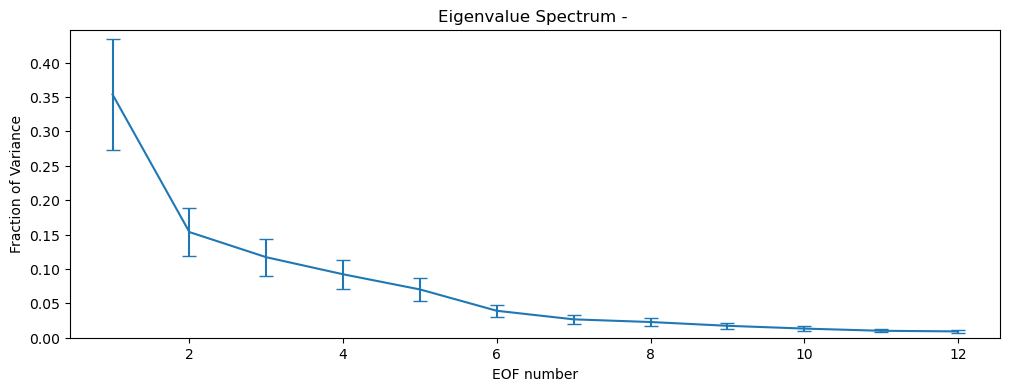

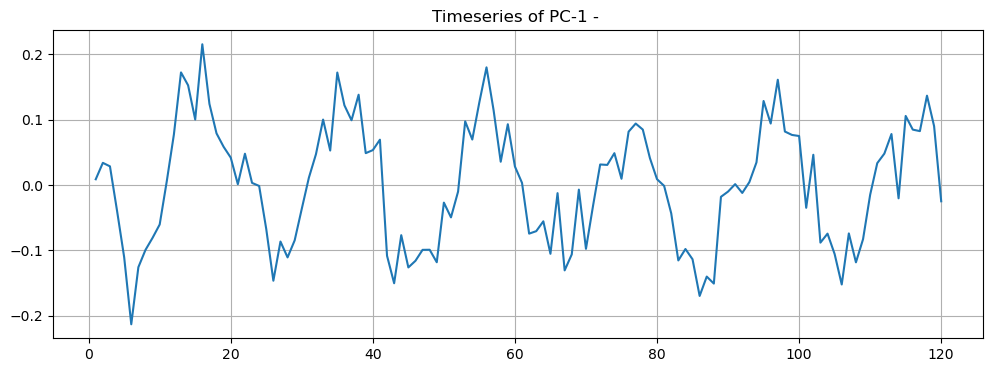

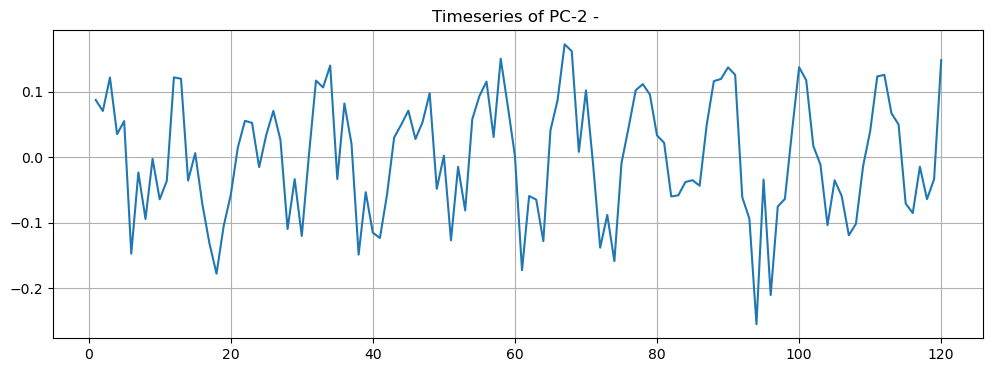

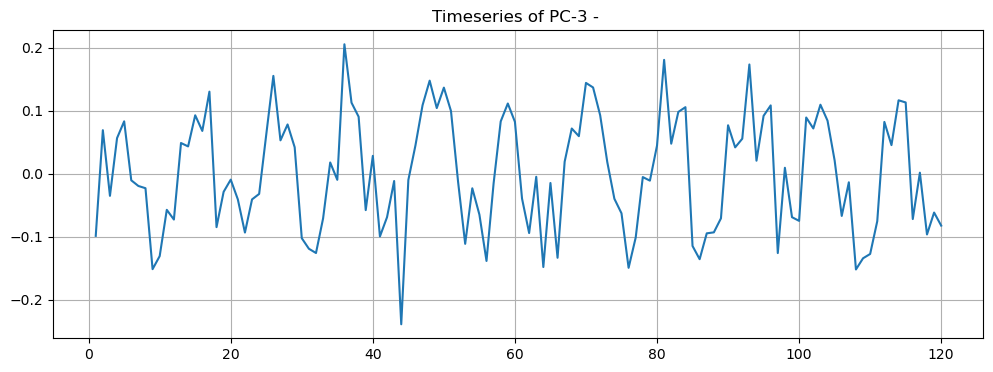

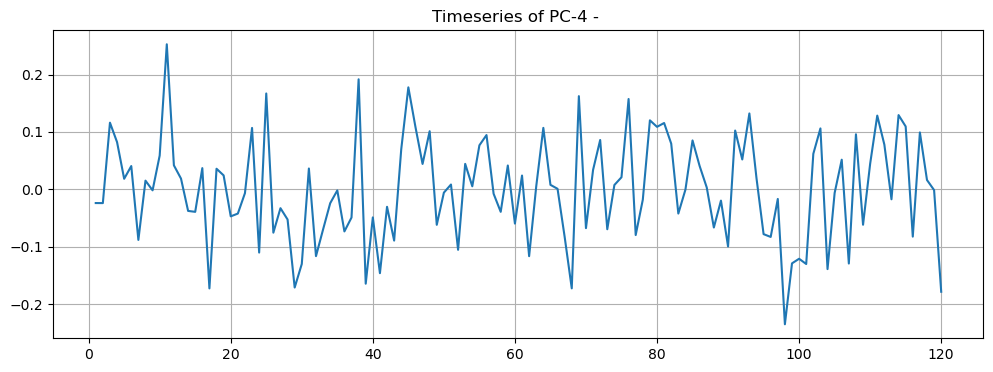

In [61]:
c = np.matmul(x,x.T)
#c = x*x.T/N
print('shape c ',np.shape(c))     
u, s, vh = np.linalg.svd(x)
print('u shape',np.shape(u))
print('vh shape',np.shape(vh))
print('s shape',np.shape(s))
type(u)
type(vh)
type(s)
spectrum = s*s.T
spectrum = spectrum/sum(spectrum)
plt.figure(figsize=(12, 4), dpi=100)


yerror = spectrum*np.sqrt(2/dof_x)
index = np.linspace(0,24,25)
    
plt.errorbar(index[1:13],spectrum[0:12],yerror[0:12],capsize=5)
plt.ylabel('Fraction of Variance')
plt.xlabel('EOF number')
plt.title('Eigenvalue Spectrum - '  )  
plt.ylim([0., max(spectrum+yerror)*1.03])
#  We need to construct the EOF map by regressing the pc onto the original data
pcmx=4  # were going to consider the first 4 eofs

ts = vh[0:pcmx,:]  # hope this is time series of first eof, YES looks right, has autocorrelation
tsamp = np.dot(ts,ts.T)
print('tsamp ',tsamp)
years = np.linspace(1,N,N)
print('years shape',np.shape(years))
print('ts shape',np.shape(ts))

for pci in range(0,pcmx):
    plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(years,ts[pci,:])
    plt.title('Timeseries of PC-' + str(pci+1) +' - '  )
    plt.grid()




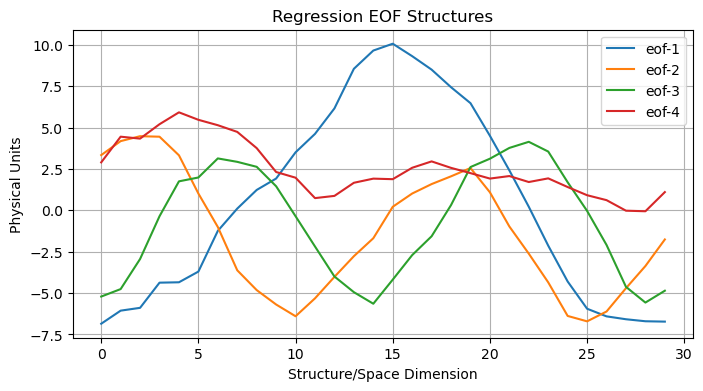

In [62]:
# here we attempt the regression:  we need to go back and get the original data

regm = np.empty([pcmx+1,M])
for pci in range(0,4):
    t=ts[pci,:]
    t = t/np.std(t)  # normalize predictor to have one standard deviation
    #print('shape t ',np.shape(t))
    #print('shape x ',np.shape(x))
    reg = np.matmul(t,x.T)/N
    #print('shape reg ',np.shape(reg))
    #regm[pci,:] = np.reshape(reg,(latx,lonx))
    regm[pci,:] = reg
    #print('shape regn ',np.shape(regm))
#  OK plot our regressed eigenfunctions
plt.figure(figsize = (8,4))
ax1 = plt.plot(regm[0:pcmx,:].T)
plt.title('Regression EOF Structures')
plt.ylabel('Physical Units')
plt.xlabel('Structure/Space Dimension')
plt.legend(['eof-1', 'eof-2', 'eof-3', 'eof-4'])
plt.grid()

shape pc  (30, 120)


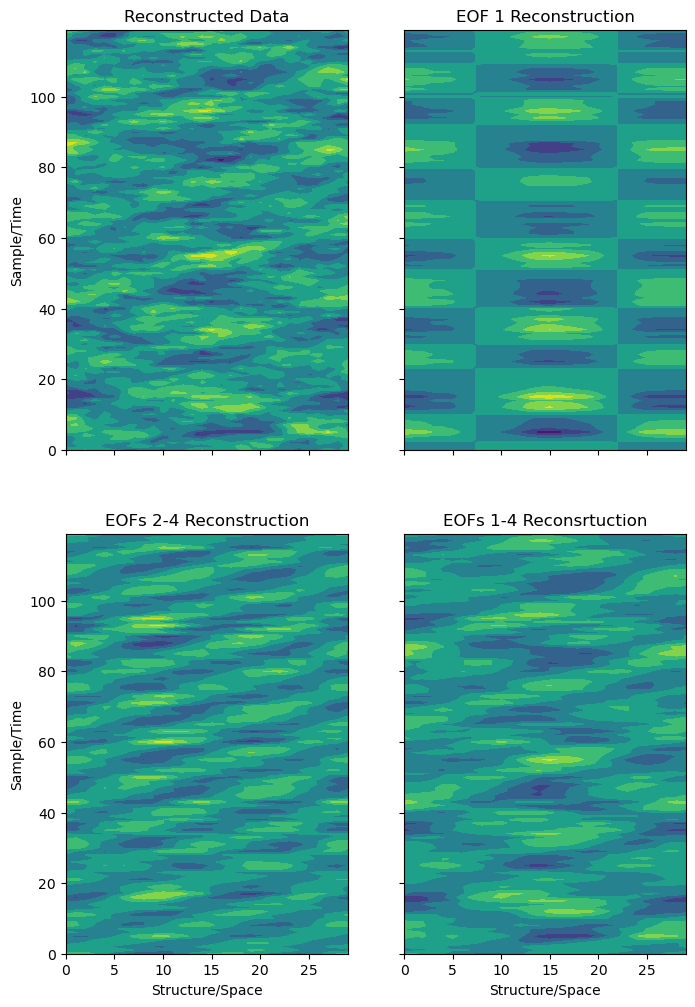

In [59]:
# at this point we have an idea that we have three dominant modes
# let's reconstruct the data set with selected modes
# to reconstruct data we multiply the pc time series times the eofs
pc = np.matmul(u.T,x)

print('shape pc ',np.shape(pc))
# to reconstruct data is EZ
xx0 = np.matmul(u,pc)

#  Can't figure out how to multiply vector times vector and get matrix
# Now do eof 1
pc1 = np.zeros((30,120),dtype=float)
pc1[0,:]=pc[0,:]
xx1 = np.matmul(u,pc1)


# Now do 2-4
pc1 = np.zeros((30,120),dtype=float)
pc1[1:3,:]=pc[1:3,:]
xx2 = np.matmul(u,pc1)

 # Now do 1-4
pc1 = np.zeros((30,120),dtype=float)
pc1[0:3,:]=pc[0:3,:]
xx3 = np.matmul(u,pc1)


fig, axs = plt.subplots(2, 2,figsize = (8,12))
axs[0, 0].contourf(xx0.T)
axs[0, 0].set_title('Reconstructed Data')
axs[0, 1].contourf(xx1.T)
axs[0, 1].set_title('EOF 1 Reconstruction')
axs[1, 0].contourf(xx2.T)
axs[1, 0].set_title('EOFs 2-4 Reconstruction')
axs[1, 1].contourf(xx3.T)
axs[1, 1].set_title('EOFs 1-4 Reconsrtuction')

for ax in axs.flat:
    ax.set(xlabel='Structure/Space', ylabel='Sample/Time')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


In [ ]:
# singleton plots

plt.figure(figsize=(5,9))
plt.contourf(xx0.T)
plt.title('Reconstructed Input Data')
plt.xlabel('Structure/space')
plt.ylabel('Sample/time')
plt.colorbar()

print('shape xx1 ',np.shape(xx1))
plt.figure(figsize=(5,9))
plt.contourf(xx1.T)
plt.title('Reconstructed Input Data EOF 1')
plt.xlabel('Structure/space')
plt.ylabel('Sample/time')
plt.colorbar()

print('shape pc1 ',np.shape(pc1))
print('shape pc ',np.shape(pc))
print('shape xx1 ',np.shape(xx1))
plt.figure(figsize=(5,9))
plt.contourf(xx2.T)
plt.title('Reconstructed Input Data EOF 2-4')
plt.xlabel('Structure/space')
plt.ylabel('Sample/time')
plt.colorbar()

print('shape pc1 ',np.shape(pc1))
print('shape pc ',np.shape(pc))
print('shape xx1 ',np.shape(xx1))
plt.figure(figsize=(5,9))
plt.contourf(xx3.T)
plt.title('Reconstructed Input Data EOF 1-4')
plt.xlabel('Structure/space')
plt.ylabel('Sample/time')
plt.colorbar()